# Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from ast import literal_eval

In [5]:
pip install numpy==1.23.4

   ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.7 MB 325.1 kB/s eta 0:00:46
   ---------------------------------------- 0.0/14.7 MB 388.9 kB/s eta 0:00:38
   ---------------------------------------- 0.1/14.7 MB 435.7 kB/s eta 0:00:34
   ---------------------------------------- 0.1/14.7 MB 351.4 kB/s eta 0:00:42
   ---------------------------------------- 0.1/14.7 MB 451.8 kB/s eta 0:00:33
   ---------------------------------------- 0.1/14.7 MB 423.5 kB/s eta 0:00:35
   ---------------------------------------- 0.2/14.7 MB 435.7 kB/s eta 0:00:34
    --------------------------------------- 0.2/14.7 MB 497.6 kB/s eta 0:00:30
    --------------------------------------- 0.2/14.7 MB 533.8 kB/s eta 0:00:28
    --------------------------------------- 0.2/14.7 MB 533.8 kB/s eta 0:00:28
    --------------------------------------- 0.3/14.7 MB 519.7 kB/s eta

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires clang~=5.0, which is not installed.
tensorboard 2.6.0 requires google-auth<2,>=1.6.3, but you have google-auth 2.22.0 which is incompatible.
tensorflow 2.6.0 requires absl-py~=0.10, but you have absl-py 2.1.0 which is incompatible.
tensorflow 2.6.0 requires flatbuffers~=1.12, but you have flatbuffers 20210226132247 which is incompatible.


# Data Loading

In [2]:
file_path = 'data.csv'

In [3]:
df = pd.read_csv(file_path)

In [4]:
df.columns

Index(['Long', 'Lat', 'Size', 'Light', 'Price_Booking1', 'Price_Booking2',
       'Price_Booking3', 'Price_Booking4', 'Price_Booking5', 'Price_Booking6',
       ...
       'Price_Booking511', 'Price_Booking512', 'Price_Booking513',
       'Price_Booking514', 'Price_Booking515', 'Price_Booking516',
       'Price_Booking517', 'Price_Booking518', 'Price_Booking519',
       'Price_Booking520'],
      dtype='object', length=524)

Price_Booking values are not suitable to use as tuples I separated values price and booking_ratio

In [5]:
average_prices = {}
booking_ratios = {}
weekly_revenues = {}

for i in range(1, 521):
    column_name = f'Price_Booking{i}'
    # Convert strings to tuples if they are not already
    df[column_name] = df[column_name].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

    # Prepare new columns separately
    average_prices[f'average_price{i}'] = df[column_name].apply(lambda x: x[0])
    booking_ratios[f'booking_ratio{i}'] = df[column_name].apply(lambda x: x[1])
    weekly_revenues[f'weekly_revenue{i}'] = df[column_name].apply(lambda x: x[0] * x[1] * 7)
    df.drop(columns=f'Price_Booking{i}', inplace=True, axis=1)
# Convert dictionaries to DataFrames
average_price_df = pd.DataFrame(average_prices)
booking_ratio_df = pd.DataFrame(booking_ratios)
weekly_revenue_df = pd.DataFrame(weekly_revenues)

# Concatenate all new DataFrames at once
df = pd.concat([df, weekly_revenue_df, average_price_df, booking_ratio_df], axis=1)

df = df.copy()

In [8]:
df.head()

,Long,Lat,Size,Light,weekly_revenue1,weekly_revenue2,weekly_revenue3,weekly_revenue4,weekly_revenue5,weekly_revenue6,...,booking_ratio511,booking_ratio512,booking_ratio513,booking_ratio514,booking_ratio515,booking_ratio516,booking_ratio517,booking_ratio518,booking_ratio519,booking_ratio520
0,5,-54,medium,0,135.901999,69.306219,139.773848,112.227282,149.083474,80.869084,...,0.8098,0.1080,0.4888,0.0577,0.0434,0.0348,0.2090,0.8847,0.2190,0.2070
1,15,34,large,1,18.695317,57.786859,74.887266,99.041069,11.027450,27.723354,...,0.2932,0.0003,0.0026,0.1442,0.5035,0.0004,0.8583,0.4480,0.9208,0.0792
2,52,33,small,1,44.347306,47.109034,28.251371,3.330332,66.354832,104.397793,...,0.3989,0.8718,0.0075,0.0959,0.2264,0.0155,0.0374,0.4942,0.9249,0.0103
3,36,-32,small,0,180.714657,123.163511,180.788020,87.430023,67.247760,113.274359,...,0.3075,0.4246,0.8802,0.0830,0.3801,0.5986,0.8888,0.0999,0.8736,0.4038
4,29,49,medium,0,57.936356,159.117393,164.657600,149.429804,63.293161,79.321350,...,0.8544,0.5271,0.2676,0.0898,0.0857,0.5754,0.8676,0.3303,0.2868,0.3759


In [9]:
file_path = 'weekly_rev.csv'

In [10]:
df.to_csv(file_path, index=False)

In [11]:
data = pd.read_csv(file_path)

In [12]:
data.columns

Index(['Long', 'Lat', 'Size', 'Light', 'weekly_revenue1', 'weekly_revenue2',
       'weekly_revenue3', 'weekly_revenue4', 'weekly_revenue5',
       'weekly_revenue6',
       ...
       'booking_ratio511', 'booking_ratio512', 'booking_ratio513',
       'booking_ratio514', 'booking_ratio515', 'booking_ratio516',
       'booking_ratio517', 'booking_ratio518', 'booking_ratio519',
       'booking_ratio520'],
      dtype='object', length=1564)

# Maximal revenue prediction

If reveune is maximal -> price is optimal

In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Dropout, Bidirectional

# Preparing the data
size_dummies = pd.get_dummies(data['Size'], prefix='Size')
static_features = data[['Long', 'Lat', 'Light']].join(size_dummies)
scaler = StandardScaler()
static_features = scaler.fit_transform(static_features)

# Preparing revenue data and repeating static features for each time step
revenue_data = data.filter(regex='weekly_revenue').values
revenue_data = revenue_data.reshape(revenue_data.shape[0], revenue_data.shape[1], 1)
static_features_repeated = np.repeat(static_features[:, np.newaxis, :], revenue_data.shape[1], axis=1)

# Combine revenue data with static features
combined_features = np.concatenate([revenue_data, static_features_repeated], axis=-1)
X_train, X_test, y_train, y_test = train_test_split(combined_features, revenue_data[:, -1, 0], test_size=0.2, random_state=42)

I used an LSTM model (RNN NN) for this project because time series data needs to be remembered, which can help in making more accurate predictions

In [27]:
input_shape = combined_features.shape[1:]  # Should be (520, number of features + 1)
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=input_shape),
    LSTM(50),
    Dense(1)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse')

In [24]:
model_lstm.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.1)

# Predict the revenue for week 521
week_521_revenue1 = model_lstm.predict(X_test)

Epoch 1/87
225/225 [==============================] - 16s 59ms/step - loss: 6585.6040 - val_loss: 5607.1001
Epoch 2/87
225/225 [==============================] - 13s 57ms/step - loss: 5134.8267 - val_loss: 4463.5039
Epoch 3/87
225/225 [==============================] - 13s 56ms/step - loss: 4115.0454 - val_loss: 3595.8091
Epoch 4/87
225/225 [==============================] - 12s 55ms/step - loss: 3315.8254 - val_loss: 2903.5483
Epoch 5/87
225/225 [==============================] - 12s 54ms/step - loss: 2677.2517 - val_loss: 2352.5093
Epoch 6/87
225/225 [==============================] - 12s 55ms/step - loss: 2164.7063 - val_loss: 1909.2494
Epoch 7/87
225/225 [==============================] - 12s 55ms/step - loss: 1753.1461 - val_loss: 1553.2236
Epoch 8/87
225/225 [==============================] - 12s 55ms/step - loss: 1422.9020 - val_loss: 1267.4412
Epoch 9/87
225/225 [==============================] - 12s 55ms/step - loss: 1157.4797 - val_loss: 1036.9348
Epoch 10/87
225/225 [=======

In [25]:
week_521_revenue1 = model_lstm.predict(combined_features)

In [16]:
week_521_revenue1

array([[ 97.029945],
       [ 30.134897],
       [  6.605833],
       ...,
       [145.59639 ],
       [120.92972 ],
       [107.028854]], dtype=float32)

In [26]:
week_521_revenue1

array([[ 97.07979  ],
       [ 30.246864 ],
       [  6.6757793],
       ...,
       [146.21547  ],
       [121.35243  ],
       [107.07357  ]], dtype=float32)

In [ ]:
data['weekly_revenue521'] = week_521_revenue1

In [30]:
# Define the LSTM model
model_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='mse')

# Set up ModelCheckpoint to save the best model based on validation loss
checkpoint_filepath = 'best_model.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# Fit the model
model_lstm.fit(X_train, y_train, epochs=120, batch_size=32, validation_split=0.1,
               callbacks=[model_checkpoint_callback])

Epoch 1/120
225/225 [==============================] - 16s 60ms/step - loss: 6927.5820 - val_loss: 5896.1406
Epoch 2/120
225/225 [==============================] - 13s 56ms/step - loss: 5438.6953 - val_loss: 4708.2041
Epoch 3/120
225/225 [==============================] - 13s 57ms/step - loss: 4328.2998 - val_loss: 3767.9231
Epoch 4/120
225/225 [==============================] - 13s 58ms/step - loss: 3471.5334 - val_loss: 3032.5303
Epoch 5/120
225/225 [==============================] - 13s 56ms/step - loss: 2792.4727 - val_loss: 2447.0713
Epoch 6/120
225/225 [==============================] - 13s 56ms/step - loss: 2251.2241 - val_loss: 1981.3324
Epoch 7/120
225/225 [==============================] - 12s 55ms/step - loss: 1818.6650 - val_loss: 1609.3092
Epoch 8/120
225/225 [==============================] - 13s 56ms/step - loss: 1472.1075 - val_loss: 1307.6410
Epoch 9/120
225/225 [==============================] - 13s 56ms/step - loss: 1194.2037 - val_loss: 1067.1467
Epoch 10/120
225/22

In [31]:
# Load the best model
best_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])
best_model.load_weights(checkpoint_filepath)

In [32]:
# Print the parameters of the best model
print("Parameters of the Best Model:")
for layer in best_model.layers:
    weights = layer.get_weights()  # List of numpy arrays
    print(f"Layer {layer.name} parameters:")
    for i, weight in enumerate(weights):
        print(f"  Weight[{i}]: {weight.shape}")

# Predict the revenue for week 521 using the best model
week_521_revenue = best_model.predict(X_test)
print("Predicted revenue for week 521:", week_521_revenue)

Parameters of the Best Model:
Layer lstm_12 parameters:
  Weight[0]: (7, 200)
  Weight[1]: (50, 200)
  Weight[2]: (200,)
Layer lstm_13 parameters:
  Weight[0]: (50, 200)
  Weight[1]: (50, 200)
  Weight[2]: (200,)
Layer dense_6 parameters:
  Weight[0]: (50, 1)
  Weight[1]: (1,)
Predicted revenue for week 521: [[ 50.493053]
 [ 58.20168 ]
 [101.9081  ]
 ...
 [ 81.02727 ]
 [ 77.836945]
 [118.08573 ]]


In [33]:
df_bench = pd.read_csv('benchmark_data.csv')

In [34]:
df_bench

,Long,Lat,Size,Light,Price_Booking1,Price_Booking2,Price_Booking3,Price_Booking4,Price_Booking5,Price_Booking6,...,Price_Booking511,Price_Booking512,Price_Booking513,Price_Booking514,Price_Booking515,Price_Booking516,Price_Booking517,Price_Booking518,Price_Booking519,Price_Booking520
0,11,-8,small,1,"(44.07422740778878, 0.2244)","(10.235745495054404, 0.8771)","(77.44432192100861, 0.0115)","(32.682854325706636, 0.4374)","(93.07005020369597, 0.0016)","(59.55342009850416, 0.0712)",...,"(3.503511792465819, 0.8693)","(21.207831688891897, 0.6324)","(37.472733112480896, 0.3145)","(17.68477270798783, 0.7076)","(3.9349006656278496, 0.8869)","(90.75592780176181, 0.0021)","(57.12871533905361, 0.082)","(48.73808820675718, 0.1592)","(12.213765932305831, 0.8287)","(50.82865199262406, 0.1387)"
1,-23,50,large,0,"(27.403085749044997, 0.6838)","(67.88625315230517, 0.1343)","(58.481870400767434, 0.224)","(56.95623287755157, 0.2431)","(4.993203977397098, 0.9579)","(42.47182196384385, 0.4534)",...,"(21.379118386361394, 0.7227)","(58.91370302091187, 0.2023)","(4.511084912965702, 0.8782)","(49.94310488165724, 0.3095)","(11.68847681410703, 0.8466)","(69.85385620221606, 0.1142)","(30.52089300740838, 0.6134)","(72.41102332280923, 0.0994)","(39.81837685219315, 0.4723)","(88.06567678260058, 0.0348)"
2,10,-45,medium,0,"(32.49922734531039, 0.6368)","(27.27239937360443, 0.7202)","(36.20418901494742, 0.5888)","(81.40103513141597, 0.0835)","(71.81075706852077, 0.1446)","(18.065003797032787, 0.8636)",...,"(17.42772963166037, 0.7843)","(7.484976054849901, 0.8631)","(25.601585429981, 0.6956)","(50.3850166054486, 0.3494)","(16.117362334552887, 0.8151)","(14.195214120071231, 0.8388)","(44.23375456195849, 0.4425)","(83.32192167215457, 0.0709)","(54.16402788999447, 0.3136)","(25.087128491645018, 0.7394)"
3,-4,3,small,1,"(92.82272915578096, 0.0011)","(24.132065502164757, 0.6006)","(63.09560763988213, 0.0423)","(33.327256606541425, 0.403)","(33.69975089548419, 0.3979)","(73.18542895745563, 0.0147)",...,"(69.74082104797938, 0.0195)","(38.80884537040286, 0.271)","(63.16126548911956, 0.039)","(88.27001407634896, 0.002)","(74.70630932807055, 0.0114)","(92.17872999659934, 0.0012)","(97.04303626476803, 0.0006)","(2.4528886659984206, 0.9133)","(59.1714243644762, 0.0596)","(61.30086613145307, 0.0492)"
4,-2,15,small,1,"(49.80177382910645, 0.1483)","(54.07334498175166, 0.1074)","(45.903234713953736, 0.1989)","(77.4330848736851, 0.0111)","(65.96155090109079, 0.0379)","(5.084813285843259, 0.9554)",...,"(66.97356607076182, 0.0311)","(91.1566259740697, 0.0018)","(85.68419936773684, 0.0037)","(75.55400762308903, 0.0127)","(48.515525854018584, 0.1555)","(60.91412796408466, 0.057)","(39.00983918378642, 0.2932)","(19.47406031706128, 0.6919)","(94.582862203968, 0.0012)","(35.19505761977505, 0.3708)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,54,46,large,0,"(38.92010905514978, 0.6391)","(43.67199655852267, 0.5828)","(79.3108073425907, 0.1922)","(33.835143318405905, 0.7183)","(8.094740680730572, 0.952)","(30.051272039367525, 0.7738)",...,"(16.501405960541682, 0.8184)","(48.548879030391035, 0.4833)","(92.11811494885823, 0.1019)","(25.932470821018295, 0.7508)","(55.42036821166823, 0.4102)","(57.53425442297285, 0.3887)","(50.4710198315531, 0.4757)","(59.57297892738654, 0.3715)","(52.41657965896061, 0.4593)","(84.69875384380687, 0.1499)"
1996,-33,30,small,1,"(63.414821080339145, 0.1132)","(96.5251344234855, 0.007)","(48.693655619087295, 0.274)","(83.48267652523833, 0.0245)","(38.41139224623771, 0.4452)","(35.417629666876074, 0.5032)",...,"(16.825458038755116, 0.7557)","(99.07768920144888, 0.005)","(36.36184221758047, 0.4416)","(86.57729771540193, 0.0172)","(35.933910870024555, 0.4546)","(94.78582147599467, 0.008)","(42.88209797584985, 0.3458)","(87.63162373682749, 0.0161)","(74.36260170592735, 0.0503)","(48.352661829682454, 0.2723)"
1997,32,-44,large,1,"(78.75671906763031, 0.0079)","(85.83768213401827, 0.0032)","(94.06346122190314, 0.001)","(2

In [35]:
average_prices_b = {}
booking_ratios_b = {}
weekly_revenues_b = {}

for i in range(1, 521):
    column_name = f'Price_Booking{i}'
    # Convert strings to tuples if they are not already
    df_bench[column_name] = df_bench[column_name].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

    # Prepare new columns separately
    average_prices_b[f'average_price{i}'] = df_bench[column_name].apply(lambda x: x[0])
    booking_ratios_b[f'booking_ratio{i}'] = df_bench[column_name].apply(lambda x: x[1])
    weekly_revenues_b[f'weekly_revenue{i}'] = df_bench[column_name].apply(lambda x: x[0] * x[1] * 7)
    df_bench.drop(columns=f'Price_Booking{i}', inplace=True, axis=1)
# Convert dictionaries to DataFrames
average_price_bdf = pd.DataFrame(average_prices_b)
booking_ratio_bdf = pd.DataFrame(booking_ratios_b)
weekly_revenue_bdf = pd.DataFrame(weekly_revenues_b)

# Concatenate all new DataFrames at once
df_bench = pd.concat([df_bench, weekly_revenue_bdf, average_price_bdf, booking_ratio_bdf], axis=1)

df_bench = df_bench.copy()

In [36]:
df_bench.head()

,Long,Lat,Size,Light,weekly_revenue1,weekly_revenue2,weekly_revenue3,weekly_revenue4,weekly_revenue5,weekly_revenue6,...,booking_ratio511,booking_ratio512,booking_ratio513,booking_ratio514,booking_ratio515,booking_ratio516,booking_ratio517,booking_ratio518,booking_ratio519,booking_ratio520
0,11,-8,small,1,69.231796,62.844407,6.234268,100.068363,1.042385,29.681425,...,0.8693,0.6324,0.3145,0.7076,0.8869,0.0021,0.0820,0.1592,0.8287,0.1387
1,-23,50,large,0,131.167610,63.819867,91.699573,96.922421,33.480931,134.797069,...,0.7227,0.2023,0.8782,0.3095,0.8466,0.1142,0.6134,0.0994,0.4723,0.0348
2,10,-45,medium,0,144.868556,137.491074,149.219185,47.578905,72.686848,109.206561,...,0.7843,0.8631,0.6956,0.3494,0.8151,0.8388,0.4425,0.0709,0.3136,0.7394
3,-4,3,small,1,0.714735,101.456030,18.682609,94.016191,93.863916,7.530781,...,0.0195,0.2710,0.0390,0.0020,0.0114,0.0012,0.0006,0.9133,0.0596,0.0492
4,-2,15,small,1,51.699221,40.652341,63.911074,6.016551,17.499599,34.006214,...,0.0311,0.0018,0.0037,0.0127,0.1555,0.0570,0.2932,0.6919,0.0012,0.3708


In [37]:
size_dummies_b = pd.get_dummies(df_bench['Size'], prefix='Size')
static_features_b = df_bench[['Long', 'Lat', 'Light']].join(size_dummies_b)
scaler = StandardScaler()
static_features_b = scaler.fit_transform(static_features_b)

# Preparing revenue data and repeating static features for each time step
revenue_data_b = df_bench.filter(regex='weekly_revenue').values
revenue_data_b = revenue_data_b.reshape(revenue_data_b.shape[0], revenue_data_b.shape[1], 1)
static_features_repeated_b = np.repeat(static_features_b[:, np.newaxis, :], revenue_data_b.shape[1], axis=1)

# Combine revenue data with static features
combined_features = np.concatenate([revenue_data_b, static_features_repeated_b], axis=-1)

Model trained for data used to predict benchmark weekly_revenue521

In [39]:
week_521_revenue_b = best_model.predict(combined_features)

In [40]:
week_521_revenue_b

array([[ 49.356518],
       [ 21.360485],
       [129.72858 ],
       ...,
       [ 74.04793 ],
       [117.42016 ],
       [132.29874 ]], dtype=float32)

In [132]:
df_bench['weekly_revenue521'] = week_521_revenue_b

In [133]:
df_bench['weekly_revenue521']

0        49.356518
1        21.360485
2       129.728577
3        21.055195
4        91.550743
           ...    
1995     88.604553
1996     92.169067
1997     74.047928
1998    117.420158
1999    132.298737
Name: weekly_revenue521, Length: 2000, dtype: float32

# Weekly Average Price and Booking Ratio relation

In [116]:
filtered_df = df_bench.filter(regex='^(average_price|booking_ratio)')

In [117]:
filtered_df

,average_price1,average_price2,average_price3,average_price4,average_price5,average_price6,average_price7,average_price8,average_price9,average_price10,...,booking_ratio511,booking_ratio512,booking_ratio513,booking_ratio514,booking_ratio515,booking_ratio516,booking_ratio517,booking_ratio518,booking_ratio519,booking_ratio520
0,44.074227,10.235745,77.444322,32.682854,93.070050,59.553420,8.500513,21.970928,93.906537,86.610440,...,0.8693,0.6324,0.3145,0.7076,0.8869,0.0021,0.0820,0.1592,0.8287,0.1387
1,27.403086,67.886253,58.481870,56.956233,4.993204,42.471822,57.411377,96.337717,5.062147,94.486441,...,0.7227,0.2023,0.8782,0.3095,0.8466,0.1142,0.6134,0.0994,0.4723,0.0348
2,32.499227,27.272399,36.204189,81.401035,71.810757,18.065004,55.501385,14.173636,49.645996,5.737980,...,0.7843,0.8631,0.6956,0.3494,0.8151,0.8388,0.4425,0.0709,0.3136,0.7394
3,92.822729,24.132066,63.095608,33.327257,33.699751,73.185429,98.633290,30.368321,0.787648,26.223341,...,0.0195,0.2710,0.0390,0.0020,0.0114,0.0012,0.0006,0.9133,0.0596,0.0492
4,49.801774,54.073345,45.903235,77.433085,65.961551,5.084813,71.945818,34.142620,12.772324,11.917745,...,0.0311,0.0018,0.0037,0.0127,0.1555,0.0570,0.2932,0.6919,0.0012,0.3708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,38.920109,43.671997,79.310807,33.835143,8.094741,30.051272,12.030133,37.424384,14.899707,98.276312,...,0.8184,0.4833,0.1019,0.7508,0.4102,0.3887,0.4757,0.3715,0.4593,0.1499
1996,63.414821,96.525134,48.693656,83.482677,38.411392,35.417630,54.864760,7.573367,3.150291,46.112817,...,0.7557,0.0050,0.4416,0.0172,0.4546,0.0080,0.3458,0.0161,0.0503,0.2723
1997,78.756719,85.837682,94.063461,28.960625,80.025381,88.333021,49.026680,15.772745,90.842968,55.334324,...,0.0356,0.7987,0.4120,0.0029,0.0014,0.6548,0.0006,0.0375,0.0004,0.8214
1998,9.971771,43.748333,76.780431,69.485612,45.632420,20.855097,34.691470,53.437203,80.433463,78.100971,...,0.4467,0.4350,0.8155,0.7813,0.4293,0.7527,0.6186,0.2726,0.7957,0.8210


In [45]:
# Correlation
for i in range(1,521):
  print(filtered_df[f'average_price{i}'].corr(filtered_df[f'booking_ratio{i}']))

-0.9285218255536773
-0.9305331653757579
-0.9308203934142316
-0.9282982084942761
-0.92832679814296
-0.9289976250783967
-0.9302398040035299
-0.9322528401968061
-0.9320401078970694
-0.9340990854379893
-0.93038008116756
-0.9277326329194073
-0.9332739235401223
-0.9319923048764994
-0.9277201765232724
-0.9295565881110056
-0.9358177835380271
-0.9354717308056337
-0.9298857001878824
-0.9294879173710717
-0.9324242609450549
-0.9307545891234862
-0.9342944030879615
-0.9324772767143972
-0.9317617441468906
-0.9373686296425873
-0.9296664698363345
-0.9307977130922285
-0.9339789457888032
-0.9282990801117765
-0.9308511773509736
-0.9284485172957131
-0.9298563283121754
-0.9315160908506455
-0.9295751078685401
-0.9303255063940973
-0.9319652526274576
-0.9316049354087118
-0.9307422054717867
-0.9285128644291383
-0.9352413062899461
-0.9307731488949296
-0.9317852126115314
-0.9293803779055153
-0.9319968508700173
-0.9322907575140782
-0.9349941242818323
-0.9314850183021179
-0.9301492752353109
-0.9325854439601218
-0.9

Correlation between booking_ratio and average price about -0.93, which interpred as strong negative relation

In [118]:
price_columns = [col for col in filtered_df.columns if 'average_price' in col]
ratios = [col for col in filtered_df.columns if 'booking_ratio' in col]

In [134]:
df_bench.rename(columns={'weekly_revenue521': 'Prices'}, inplace=True)

In [48]:
output_file = 'output_benchmark_data.csv'

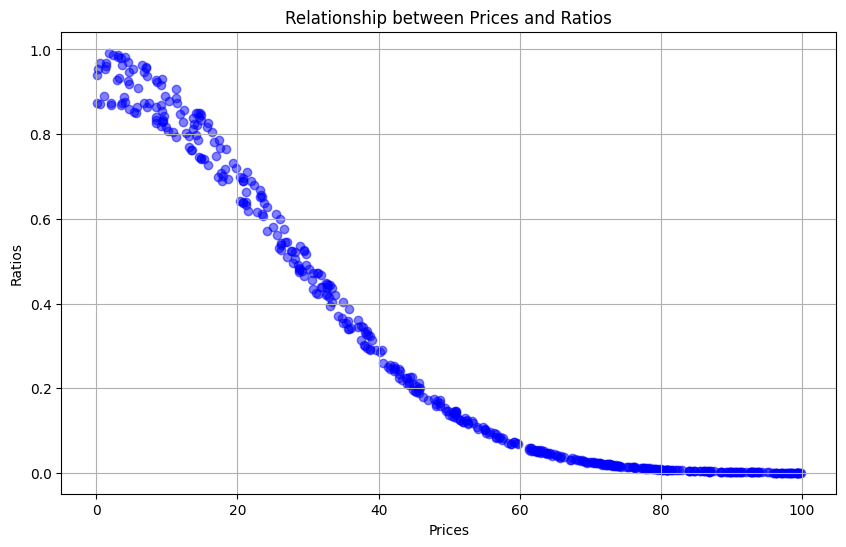

In [83]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming pred_df is already defined with 'Prices' and 'Ratios'
X = pred_df[['Prices']]
y = pred_df['Ratios']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', alpha=0.5)  # alpha is set for better visualization of data points overlap
plt.title('Relationship between Prices and Ratios')
plt.xlabel('Prices')
plt.ylabel('Ratios')
plt.grid(True)
plt.show()


There is a strong correlation between price and ratio, so a simple Linear Regression model is used to predict the booking ratio from the average price

Polynomial Regression trained to predict booking ratio from average price. Then done predictions for weekly_revenue521 (It's the highest possible price for specific revenue). Then decrease price to have price * ratio * 7 = weekly_revenue equation

In [55]:
pip install matplotlib


     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -- ------------------------------------- 10.2/162.8 kB ? eta -:--:--
     --------- --------------------------- 41.0/162.8 kB 487.6 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/162.8 kB 653.6 kB/s eta 0:00:01
     ---------------- -------------------- 71.7/162.8 kB 653.6 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/162.8 kB 655.8 kB/s eta 0:00:01
     ------------------------------------ 162.8/162.8 kB 696.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/7.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.7 MB 1.9 MB/s eta 0:00:04
    --------------------------------------- 0.1/7.7 MB 1.6 MB/s eta 0:00:05
    --------------------------------------- 0.1/7.7 MB 1.6 MB/s eta 0:00:05
    --------------------------------------- 0.1/7.7 MB 1.6 MB/s eta 0:00:05
    --------------------------------------- 0.1/7.7 MB 1.6 MB/s eta 0:00:05
    

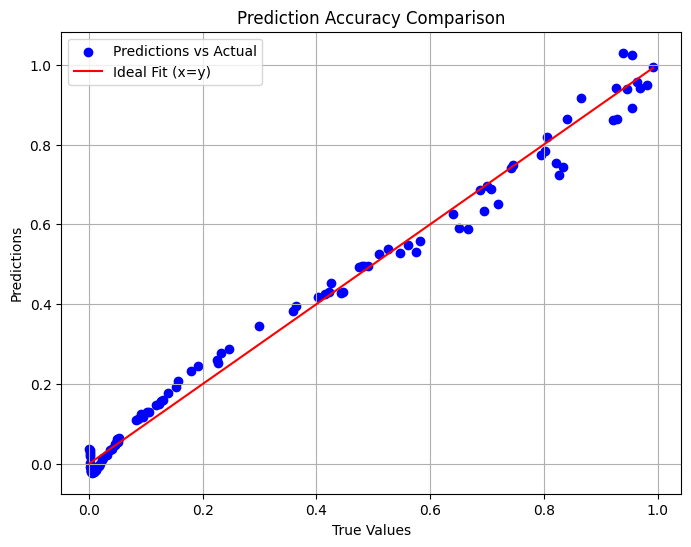

In [112]:
import matplotlib.pyplot as plt

# Assuming y_test and prediction_ are defined and contain your data
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', label='Predictions vs Actual')  # Scatter plot of predictions vs actual
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r', label='Ideal Fit (x=y)')  # Line x=y

# Adding labels and title
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Prediction Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [153]:
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define alpha for Ridge regularization
alpha = 0.1 

# Initialize lists to store evaluation metrics
r2_scores = []
rmse_scores = []
Price_Booking521 = []

for i in range(filtered_df.shape[0]):
    # Extract prices and ratios
    transposed_prices = filtered_df[price_columns].iloc[i].T
    trans_ratios = filtered_df[ratios].iloc[i].T

    values_array = transposed_prices.to_numpy()
    v_arr = trans_ratios.to_numpy()

    pred_df = pd.DataFrame({
        'Prices': values_array.flatten(),
        'Ratios': v_arr.flatten()
    })

    X = pred_df[['Prices']]
    y = pred_df['Ratios']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize polynomial regression model with Ridge regression
    model = make_pipeline(PolynomialFeatures(degree=3), Ridge(alpha=alpha))

    # Fit the model
    model.fit(X_train, y_train)

    # Predict ratios for the price from df_bench
    price_start = df_bench[['Prices']].iloc[[i]]
   
    prediction_ = model.predict(price_start)
    print(f'prediction_ is {prediction_}')
    #pred_st = prediction_
    price_start = price_start.values.reshape(-1)
    print(f'pirce_start is {price_start}')
    x = price_start
    print(f'x is {x}')

    # Find the closest price
    while (x * 7 * prediction_ < price_start) and (x > 0):
        x -= 0.1 
        tmp_df = pd.DataFrame({
            'Prices':x.flatten(),
        })
        prediction_ = model.predict(tmp_df)

    Price_Booking521.append(x)

    # Evaluate the model using cross-validation
    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    r2_scores_cv = cross_val_score(model, X, y, cv=kf, scoring='r2')
    r2_scores.append(np.mean(r2_scores_cv))
    mse_scores_cv = cross_val_score(model, X, y, cv=kf, scoring=make_scorer(mean_squared_error))
    rmse_scores.append(np.mean(np.sqrt(mse_scores_cv)))

# Print average evaluation metrics
print('Polynomial Ridge Regression:')
print('Average R²:', np.mean(r2_scores))
print('Average RMSE:', np.mean(rmse_scores))


prediction_ is [0.1936765]
pirce_start is [49.356518]
x is [49.356518]
prediction_ is [0.7490029]
pirce_start is [21.360485]
x is [21.360485]
prediction_ is [0.5833561]
pirce_start is [129.72858]
x is [129.72858]
prediction_ is [0.61193858]
pirce_start is [21.055195]
x is [21.055195]
prediction_ is [-0.0003734]
pirce_start is [91.55074]
x is [91.55074]
prediction_ is [0.77713169]
pirce_start is [20.202526]
x is [20.202526]
prediction_ is [0.06471658]
pirce_start is [101.85814]
x is [101.85814]
prediction_ is [0.32981861]
pirce_start is [37.977997]
x is [37.977997]
prediction_ is [0.05645537]
pirce_start is [99.37648]
x is [99.37648]
prediction_ is [0.90255394]
pirce_start is [6.9423866]
x is [6.9423866]
prediction_ is [0.89120333]
pirce_start is [8.344255]
x is [8.344255]
prediction_ is [0.68106663]
pirce_start is [30.448498]
x is [30.448498]
prediction_ is [2.03979321]
pirce_start is [172.70346]
x is [172.70346]
prediction_ is [0.81699882]
pirce_start is [13.948017]
x is [13.948017]
p

In [135]:
df_bench.columns

Index(['Long', 'Lat', 'Size', 'Light', 'weekly_revenue1', 'weekly_revenue2',
       'weekly_revenue3', 'weekly_revenue4', 'weekly_revenue5',
       'weekly_revenue6',
       ...
       'booking_ratio513', 'booking_ratio514', 'booking_ratio515',
       'booking_ratio516', 'booking_ratio517', 'booking_ratio518',
       'booking_ratio519', 'booking_ratio520', 'weekly_recenue521', 'Prices'],
      dtype='object', length=1566)

In [154]:
Price_Booking521

[array([49.356518], dtype=float32),
 array([21.360485], dtype=float32),
 array([129.72858], dtype=float32),
 array([21.055195], dtype=float32),
 array([53.15133], dtype=float32),
 array([20.202526], dtype=float32),
 array([68.35865], dtype=float32),
 array([37.977997], dtype=float32),
 array([66.77698], dtype=float32),
 array([6.9423866], dtype=float32),
 array([8.344255], dtype=float32),
 array([30.448498], dtype=float32),
 array([172.70346], dtype=float32),
 array([13.948017], dtype=float32),
 array([66.980446], dtype=float32),
 array([46.25772], dtype=float32),
 array([115.96265], dtype=float32),
 array([4.181142], dtype=float32),
 array([47.09282], dtype=float32),
 array([11.547459], dtype=float32),
 array([1.1090516], dtype=float32),
 array([48.0243], dtype=float32),
 array([0.98896813], dtype=float32),
 array([152.63058], dtype=float32),
 array([2.3339622], dtype=float32),
 array([12.140338], dtype=float32),
 array([71.10399], dtype=float32),
 array([18.12866], dtype=float32),
 a

In [155]:
prices = [item[0] for item in Price_Booking521]

In [156]:
price_booking_df = pd.DataFrame(prices, columns=['Price_Booking521'])

In [157]:
price_booking_df

,Price_Booking521
0,49.356518
1,21.360485
2,129.728577
3,21.055195
4,53.151329
...,...
1995,84.104622
1996,60.969543
1997,52.348259
1998,117.420158


In [158]:
price_booking_df.to_csv(output_file, index=False)